<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial_for_Neural_Network_Verification_with_Marabou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification with Marabou

---

*As an example we try to verifiy the **robustness** of a classification Network trained on the MNIST dataset using the [Marabou library](https://github.com/NeuralNetworkVerification/Marabou).*

[Marabou documenation](https://neuralnetworkverification.github.io/Marabou/)

---

## Neural Network Training

In [1]:
%%capture

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/mnist_trainer.py'}

In [2]:
import mnist_trainer

First, we will train a neural network with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset

In [121]:
import torch
from torch import nn
import numpy as np

import torch.onnx

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
%%capture
train_dataloader, test_dataloader = mnist_trainer.load_dataset(batch_size=64)

In [6]:
model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 148.68it/s]


Test Error: 
 Accuracy: 90.6%, Avg loss: 0.313459 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 151.69it/s]


Test Error: 
 Accuracy: 92.3%, Avg loss: 0.260063 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 150.31it/s]


Test Error: 
 Accuracy: 93.1%, Avg loss: 0.227412 

Done!


## Export the neural network

In [7]:
%pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 12.8 MB/s 
     |████████████████████████████████| 5.2 MB 53.6 MB/s 


In [11]:
model_filename = "mnist_net.onnx"

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = torch.randn(1, 28, 28).to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['image'],
                  output_names=['classification'],
                  )

## Installing Marabou

In [12]:
!git clone https://github.com/NeuralNetworkVerification/Marabou.git

Cloning into 'Marabou'...
remote: Enumerating objects: 25698, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 25698 (delta 4), reused 3 (delta 0), pack-reused 25686
Receiving objects: 100% (25698/25698), 208.52 MiB | 27.47 MiB/s, done.
Resolving deltas: 100% (18527/18527), done.


The following script builds and installs marabou. It works in Google Colab (%%shell is colab specific) and takes about 15 minutes there.

In [73]:
%%shell
cd Marabou
mkdir build
cd build
cmake .. -DBUILD_PYTHON=ON
cmake --build .
cd /content

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Building Release build
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found Boost: /usr/include (found version "1.65.1") found components: program_options timer chrono thread

add marabou to pythonpath

In [74]:
import sys
sys.path.insert(1, '/content/Marabou')

https://neuralnetworkverification.github.io/Marabou/Examples/2_ONNXExample.html

import marabou

In [78]:
from maraboupy import Marabou
import numpy as np

In [79]:
options = Marabou.createOptions(verbosity = 0)

load network in onnx format in marabou

In [80]:
network = Marabou.read_onnx(model_filename)

choose a fixed input image

In [143]:
inputs, classes = next(iter(train_dataloader))
image = inputs[0].numpy()[0]
correct_class = classes[0].numpy()

predict with network

In [150]:
network_ouput = network.evaluateWithoutMarabou([image])[0]
predicted_class = np.argmax(network_ouput)

plot the image

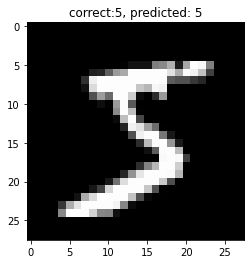

In [151]:
import matplotlib.pyplot as plt
plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(image.reshape(28,28), cmap='gray')

choose epsilon

In [152]:
epsilon = 0.5

get input and output marabou variables from network

In [161]:
inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0][0]

robustness

input constraints

In [158]:
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    network.setLowerBound(inputVars[h][w], image[h][w] - epsilon)
    network.setUpperBound(inputVars[h][w], image[h][w] + epsilon)

output constraints

In [162]:
for h in range(outputVars.shape[0]):
  network.setUpperBound(outputVars[h], outputVars[correct_class])

solve with marabou

In [165]:
exit_code, vals, stats = network.solve(options = options)

sat
input 0 = -0.5
input 1 = -0.5
input 2 = -0.5
input 3 = -0.5
input 4 = -0.5
input 5 = -0.5
input 6 = -0.5
input 7 = -0.5
input 8 = -0.5
input 9 = -0.5
input 10 = -0.5
input 11 = -0.5
input 12 = -0.5
input 13 = -0.5
input 14 = -0.5
input 15 = -0.5
input 16 = -0.5
input 17 = -0.5
input 18 = -0.5
input 19 = -0.5
input 20 = -0.5
input 21 = -0.5
input 22 = -0.5
input 23 = -0.5
input 24 = -0.5
input 25 = -0.5
input 26 = -0.5
input 27 = -0.5
input 28 = -0.5
input 29 = -0.5
input 30 = -0.5
input 31 = -0.5
input 32 = -0.5
input 33 = -0.5
input 34 = -0.5
input 35 = -0.5
input 36 = -0.5
input 37 = -0.5
input 38 = -0.5
input 39 = -0.5
input 40 = -0.5
input 41 = -0.5
input 42 = -0.5
input 43 = -0.5
input 44 = -0.5
input 45 = -0.5
input 46 = -0.5
input 47 = -0.5
input 48 = -0.5
input 49 = -0.5
input 50 = -0.5
input 51 = -0.5
input 52 = -0.5
input 53 = -0.5
input 54 = -0.5
input 55 = -0.5
input 56 = -0.5
input 57 = -0.5
input 58 = -0.5
input 59 = -0.5
input 60 = -0.5
input 61 = -0.5
input 62 = -0.

get image from marabou vals output

In [180]:
adversarial_image = [[] for _ in range(inputVars.shape[1])]
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    adversarial_image[h].insert(w, vals[inputVars[h][w]])
adversarial_image = np.array(adversarial_image)

get output from marabou

In [187]:
outputs = []
for h in range(outputVars.shape[0]):
  outputs.insert(h, vals[outputVars[h]])
print(outputs)
print(np.argmax(outputs))

[-1.9049865633079848, 2.0676438270234274, -1.9857383298041174, -4.934074135108937, 2.7461504655920566, 0.474641509375252, -2.7545338995200694, 1.8113356075935938, -3.0184602479663782, 1.5343729582619186]
4


show adversarial example

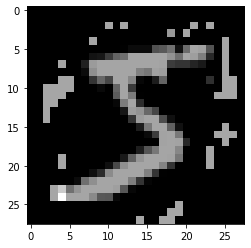

In [181]:
plt.imshow(adversarial_image, cmap='gray')

predict adversarial example with network

In [183]:
network_ouput = network.evaluateWithoutMarabou([adversarial_image])[0]
predicted_class = np.argmax(network_ouput)
print(predicted_class)

4
